In [1]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

import torch
import numpy as np
from sklearn.metrics import r2_score

from heteroscedastic import BetaGaussianMLP, BetaGaussianLM, _radius, BetaGaussianQuad

In [2]:
df_train_all = pd.read_csv('../data/cars2010.csv')
df_test_all = pd.read_csv('../data/cars2011.csv')
df_conf_all = pd.read_csv('../data/cars2011.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/cars2010.csv'

In [ ]:
# df_train_all

In [ ]:
df_train = df_train_all[['FE', 'EngDispl']].copy()
df_test = df_test_all[['FE', 'EngDispl']].copy()
df_conf = df_conf_all[['FE', 'EngDispl']].copy()

In [ ]:
# df_train

In [ ]:
y, X = dmatrices('FE ~ EngDispl', data=df_train, return_type='dataframe')
y_test, X_test = dmatrices('FE ~ EngDispl', data=df_test, return_type='dataframe')
y_conf, X_conf = dmatrices('FE ~ EngDispl', data=df_test, return_type='dataframe')

In [ ]:
#

In [ ]:
# X

In [ ]:
# plt.scatter(X.EngDispl, y.FE, marker='.')

In [3]:
# Statistically confirm that the data is(/not) heteroscedastic

ols = sm.OLS(y, X)
ols_result = ols.fit()

NameError: name 'y' is not defined

In [4]:
# residuals of a LM are dependent on X
# plt.scatter(X.EngDispl, ols_result.resid)

In [12]:
# statistical tests confirm this:
het_white(ols_result.resid, X)

(117.7420093723202,
 2.707992895937063e-26,
 65.69933201376779,
 1.1000038748270134e-27)

In [13]:
het_breuschpagan(ols_result.resid, X, robust=False)

(18.460909072394315,
 1.7342523218751654e-05,
 7.9669749301300685,
 0.004849291991016873)

In [14]:
torch.set_default_dtype(torch.double)

In [15]:
X_train = torch.from_numpy(X.to_numpy())[:, 1].unsqueeze(-1)
y_train = torch.from_numpy(y.to_numpy()).squeeze()

X_test = torch.from_numpy(X_test.to_numpy())[:, 1].unsqueeze(-1)
y_test = torch.from_numpy(y_test.to_numpy()).squeeze()

X_conf = torch.from_numpy(X_conf.to_numpy())[:, 1].unsqueeze(-1)
y_conf = torch.from_numpy(y_conf.to_numpy()).squeeze()

In [16]:
# p = np.random.permutation(len(X_train))
# X_train = X_train[p]
# y_train = y_train[p]

In [17]:
# n_test = int(.1 * len(X_torch))
# X_test, X_train = X_torch[-n_test:], X_torch[:-n_test]
# y_test, y_train = y_torch[-n_test:], y_torch[:-n_test]

In [18]:
# normalize inputs
mu = X_train.mean(dim=0)
std = torch.norm(X_train - mu, dim=0)
# mu
# # std

In [19]:
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std
# X_torch = (X_torch - mu) / std

In [20]:
X_train[:200,:].shape

torch.Size([200, 1])

In [22]:
X_torch = torch.cat((X_train, X_test))
y_torch = torch.cat((y_train, y_test))

def save_for_plot(model):
    alpha = model.alpha
    model.eval()
    
    t = torch.linspace(X_torch.min(), X_torch.max() + .1, 100).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred, sigma_sq = model(t)
        std_pred = sigma_sq.sqrt()
    
    t = t.squeeze().numpy()
    y_pred = y_pred.squeeze().numpy()
    std_pred = std_pred.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a = 2*std_pred
    else:
        # 100% confidence interval.
        R = _radius(1, alpha)
        tau = (-R**2)/2 * (std_pred**2) ** (-(alpha-1) / (alpha+1))
        a = np.sqrt(-2 * tau * std_pred**2)
        
    return t, y_pred, a

    

def plot_model(t, y_pred, a, ax, which="support", fill_color='C0'):
    ax.plot(t, y_pred, color='C0', label="predicted mean")

    ax.fill_between(t,
                    y_pred - a,
                    y_pred + a,
                    alpha=0.2, color=fill_color, label="predicted {}".format(which))
       
    # Plot the truth
    ax.scatter(X_train.squeeze().numpy(), y_train.squeeze().numpy(), marker='.', color='C1', label='train')
    ax.scatter(X_test.squeeze().numpy(), y_test.squeeze().numpy(), marker='x', color='C2', label='test')

    # ax.set_ylim(-10, 370)
    ax.set_xlim(None, t[-1])

In [23]:
# baseline

torch.manual_seed(42)
bl_model = BetaGaussianQuad(input_size=1, uncertainty=False, heteroscedastic=False, alpha=None)
optimizer = torch.optim.LBFGS(bl_model.parameters(), lr=.01, max_iter=100)

n_epochs = 1000

for epoch in range(n_epochs):
    # Forward pass
    
    def closure():
        optimizer.zero_grad()
        bl_model.train()
        loss = bl_model.loss(X_train, y_train)
        loss.backward()
        return loss

    optimizer.step(closure)

# evaluate R^2
y_pred_train = bl_model.predict(X_train).detach().numpy()
y_pred_test = bl_model.predict(X_test).detach().numpy()
print("R2 train {:.3f} test {:.3f}".format(
    r2_score(y_pred_train, y_train.numpy()),
    r2_score(y_pred_test, y_test.numpy())))
    
print("w", bl_model.lin.weight.data, "b", bl_model.lin.bias.data)

R2 train 0.531 test 0.543
w tensor([[-230.5180]]) b tensor([16.5669])


In [24]:
# try lbfgs

old_loss = np.inf

n_epochs = 1000

results = []

for j, alpha in enumerate([1, 4/3, 1.5, 2]):
    for seed in [42,]: #44, 45, 46
        torch.manual_seed(seed)
        model = BetaGaussianQuad(input_size=1, uncertainty=True, heteroscedastic=True, alpha=alpha)
        
        model.lin.weight.data[:] = bl_model.lin.weight
        model.lin.bias.data[:] = bl_model.lin.bias
        model.quad.weight.data[:] = bl_model.quad.weight
        model.quad.bias.data[:] = bl_model.quad.bias
        optimizer = torch.optim.LBFGS(model.parameters(), lr=.01, line_search_fn='strong_wolfe', max_iter=100)
        
        for epoch in range(n_epochs):
            
            def closure():
                optimizer.zero_grad()
                model.train()
                loss = model.loss(X_train, y_train)
                loss.backward()
                return loss
            
            optimizer.step(closure)
                
        # evaluate R^2
        model.eval()
        y_pred_train = model.predict(X_train).detach().numpy()
        y_pred_test = model.predict(X_test).detach().numpy()
    
        r2 = "R2 train {:.3f} test {:.3f}".format(
            r2_score(y_pred_train, y_train.numpy()),
            r2_score(y_pred_test, y_test.numpy()))
    
        results.append((alpha, save_for_plot(model), r2)) #save_for_plot(model),


In [25]:
# results

[(1,
  (array([-0.05773454, -0.05500334, -0.05227213, -0.04954092, -0.04680972,
          -0.04407851, -0.04134731, -0.0386161 , -0.03588489, -0.03315369,
          -0.03042248, -0.02769128, -0.02496007, -0.02222886, -0.01949766,
          -0.01676645, -0.01403525, -0.01130404, -0.00857284, -0.00584163,
          -0.00311042, -0.00037922,  0.00235199,  0.00508319,  0.0078144 ,
           0.01054561,  0.01327681,  0.01600802,  0.01873922,  0.02147043,
           0.02420164,  0.02693284,  0.02966405,  0.03239525,  0.03512646,
           0.03785767,  0.04058887,  0.04332008,  0.04605128,  0.04878249,
           0.0515137 ,  0.0542449 ,  0.05697611,  0.05970731,  0.06243852,
           0.06516972,  0.06790093,  0.07063214,  0.07336334,  0.07609455,
           0.07882575,  0.08155696,  0.08428817,  0.08701937,  0.08975058,
           0.09248178,  0.09521299,  0.0979442 ,  0.1006754 ,  0.10340661,
           0.10613781,  0.10886902,  0.11160023,  0.11433143,  0.11706264,
           0.1197938

Text(0.5, 0, 'EngDisplacement')

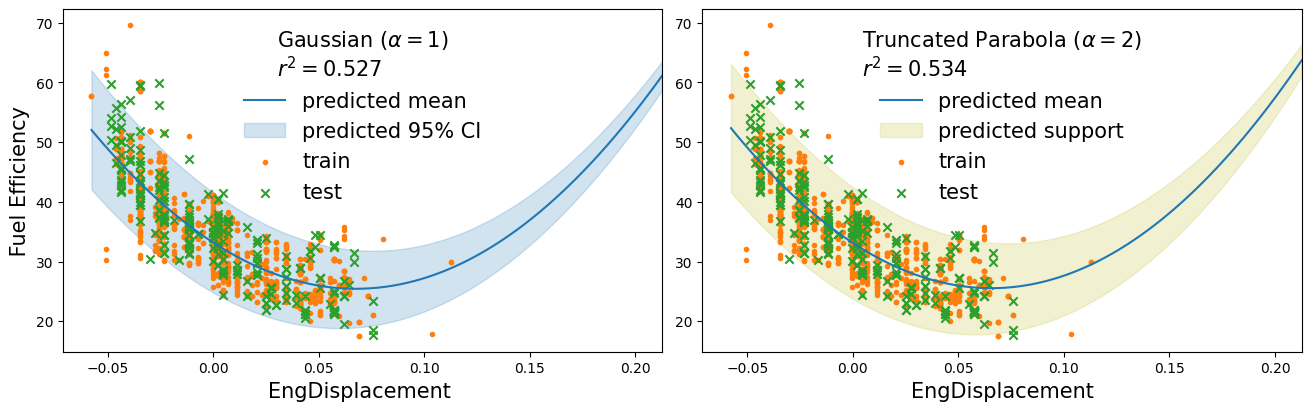

In [26]:
fig, (ax_gauss, ax_tp) = plt.subplots(1, 2, figsize=(13, 4), constrained_layout=True)

plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plot_model(*results[0][1], ax_gauss, "95% CI", fill_color='C0')
plot_model(*results[3][1], ax_tp, "support", fill_color='C8')
ax_gauss.legend(title="Gaussian ($\\alpha=1$)\n$r^2=0.527$", fontsize=15)
ax_tp.legend(title="Truncated Parabola ($\\alpha=2$)\n$r^2=0.534$", fontsize=15)
ax_gauss.set_ylabel(" Fuel Efficiency ", fontsize=15)
ax_gauss.set_xlabel("EngDisplacement ", fontsize=15)
ax_tp.set_xlabel("EngDisplacement", fontsize=15)
# plt.savefig("heteroscedastic.pdf")

In [28]:
# y_pred = results[3][1][1]
# sigma = results[3][1][2]
# sig_sq = np.square(sigma)
# plt.scatter(X_train.squeeze().numpy(), sig_sq, marker='.')


In [ ]:
# plt.fill_between(df['x'],
#                 df['lower'],
#                 df['upper'],
#                 alpha=0.2, color='blue')
# df.sort_values(by = 'x', inplace = True)
# # Plot the truth
# plt.scatter(X_train.squeeze().numpy(), y_train.squeeze().numpy(), marker='.', color='C1', label='cal')
# plt.scatter(X_test.squeeze().numpy(), y_test.squeeze().numpy(), marker='x', color='C2', label='test')
# plt.legend()

In [ ]:
# # try lbfgs

# old_loss = np.inf

# n_epochs = 1000

# results = []

# torch.manual_seed(42)
# model = BetaGaussianQuad(input_size=1, uncertainty=True, heteroscedastic=True, alpha=2)
        
# model.lin.weight.data[:] = bl_model.lin.weight
# model.lin.bias.data[:] = bl_model.lin.bias
# model.quad.weight.data[:] = bl_model.quad.weight
# model.quad.bias.data[:] = bl_model.quad.bias
# optimizer = torch.optim.LBFGS(model.parameters(), lr=.01, line_search_fn='strong_wolfe', max_iter=100)
        
# for epoch in range(n_epochs):
            
#     def closure():
#         optimizer.zero_grad()
#         model.train()
#         loss = model.loss(X_train, y_train)
#         loss.backward()
#         return loss
            
#     optimizer.step(closure)
                
#         # evaluate R^2
# model.eval()
# y_pred_train = model.predict(X_train).detach().numpy()
# y_pred_test = model.predict(X_test).detach().numpy()
    
# r2 = "R2 train {:.3f} test {:.3f}".format(
#         r2_score(y_pred_train, y_train.numpy()),
#         r2_score(y_pred_test, y_test.numpy()))
    
# alpha = model.alpha
    
# with torch.no_grad():
    
#     y_pred, sigma_sq = model(X_train)
#     std_pred = sigma_sq.sqrt()
    
#     y_pred = y_pred.squeeze().numpy()
#     std_pred = std_pred.squeeze().numpy()

#     if alpha == 1:
#         # 95% confidence interval.
#         a = 2*std_pred
#     else:
#         # 100% confidence interval.
#         R = _radius(1, alpha)
#         tau = (-R**2)/2 * (std_pred**2) ** (-(alpha-1) / (alpha+1))
#         a = np.sqrt(-2 * tau * std_pred**2)
        
# plt.plot(X_train.squeeze().numpy(), y_pred, color='C0', label="predicted mean")

# plt.fill_between(X_train.squeeze().numpy(),
#                     y_pred - a,
#                     y_pred + a,
#                     alpha=0.2, color=fill_color, label="predicted {}".format(which))
       
#     # Plot the truth
# plt.scatter(X_train.squeeze().numpy(), y_train.squeeze().numpy(), marker='.', color='C1', label='train')
# plt.scatter(X_test.squeeze().numpy(), y_test.squeeze().numpy(), marker='x', color='C2', label='test')

#     # ax.set_ylim(-10, 370)
# ax.set_xlim(None, t[-1])